In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split

import matplotlib
sns.set_style('darkgrid')
matplotlib.rc('font', size=10)
matplotlib.rc('axes', titlesize=10)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('figure', titlesize=10)

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("data/glass.csv")
df.shape

(214, 10)

In [4]:
# Detect observations with more than one outlier
from collections import Counter
def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

In [5]:
features = df.columns[:-1].tolist()
print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[features]))))

The dataset contains 14 observations with more than 2 outliers


In [6]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


In [7]:
X = df.drop("Type", axis = 1)
y = df["Type"]

In [8]:
X.shape

(200, 9)

In [9]:
y.shape

(200,)

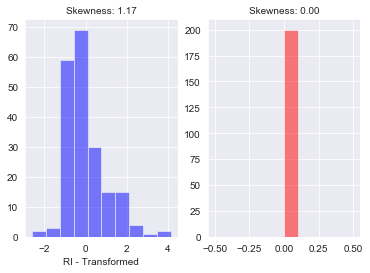

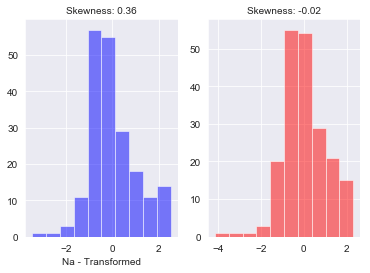

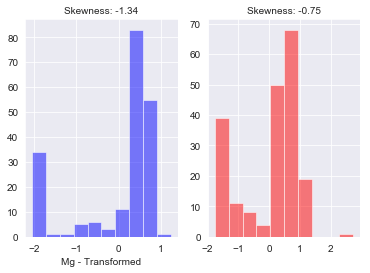

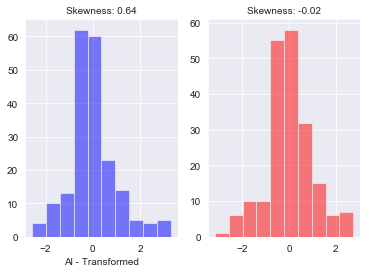

C:\Users\sarak\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


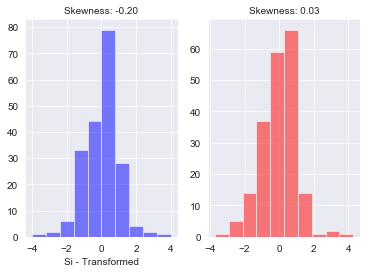

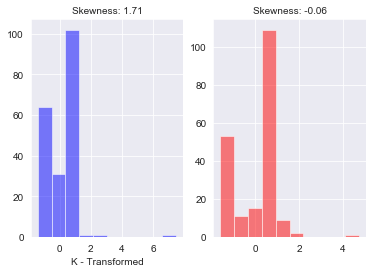

C:\Users\sarak\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


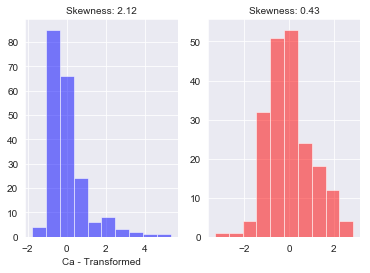

C:\Users\sarak\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


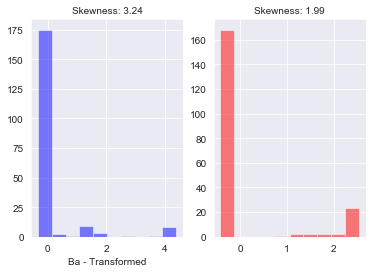

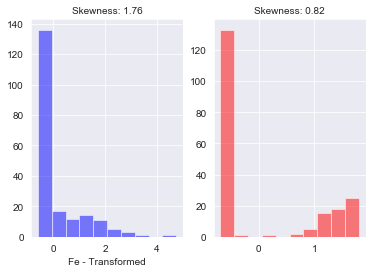

In [19]:
classes = X.columns.values
X_u = pd.DataFrame()
for c in classes:
    scaled = preprocessing.scale(X[c]) 
    boxcox_scaled = preprocessing.scale(boxcox(X[c] + np.max(np.abs(X[c]) +1))[0])
    X_u[c] = boxcox_scaled
    skness = skew(scaled)
    boxcox_skness = skew(boxcox_scaled) 
    figure = plt.figure()
    
    figure.add_subplot(121)
    plt.hist(scaled,facecolor='blue',alpha=0.5) 
    plt.xlabel(c + " - Transformed") 
    plt.title("Skewness: {0:.2f}".format(skness)) 
    
    figure.add_subplot(122) 
    plt.hist(boxcox_scaled,facecolor='red',alpha=0.5) 
    plt.title("Skewness: {0:.2f}".format(boxcox_skness)) 
    plt.show()

___
## Method 2

In [5]:
df.skew()

RI      1.625431
Na      0.454181
Mg     -1.152559
Al      0.907290
Si     -0.730447
K       6.551648
Ca      2.047054
Ba      3.416425
Fe      1.754327
Type    1.114915
dtype: float64

___
## Method 3

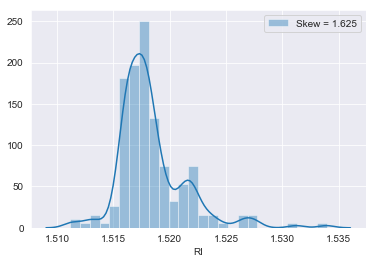

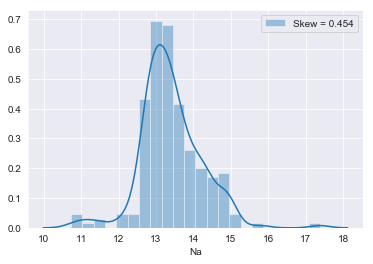

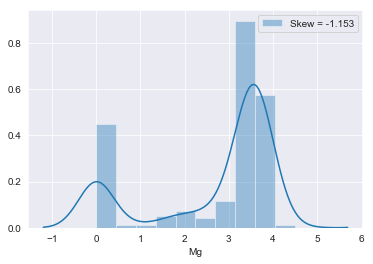

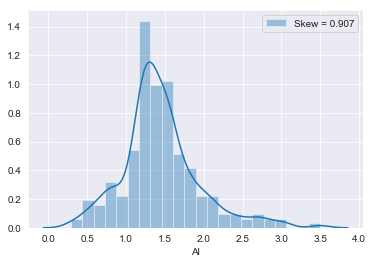

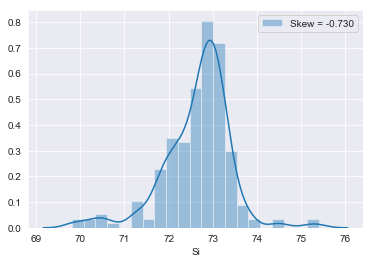

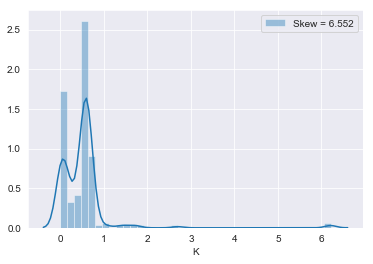

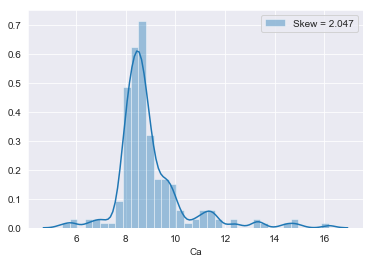

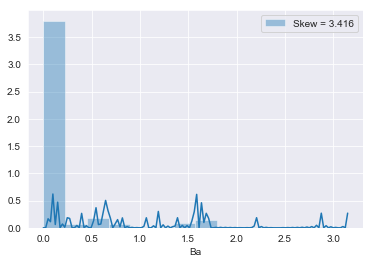

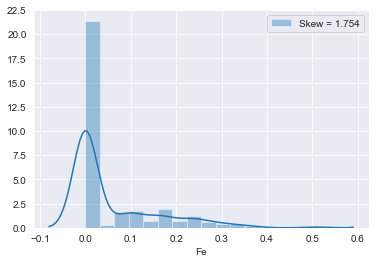

In [5]:
features = df.columns[:-1].tolist()
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], label='Skew = %.3f' %(skew))
    plt.legend(loc='best')
    plt.show()

Box-Cox transform can contribute to the normalization of some features. It should be emphasized that all transformations should only be done on the training set to avoid data snooping. Otherwise the test error estimation will be biased.

In [9]:
X = df.drop("Type", axis = 1)
y = df["Type"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [10]:
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(X_train[feature]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']

In [11]:
df_bc.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.022747,15.722915,16.342090,0.794801,2.843313e+33,0.388606,0.747677,0.000000,0.000000,1
1,0.022747,15.645066,16.808661,0.947400,2.751734e+33,0.362394,0.747365,0.000000,0.043696,1
2,0.022747,16.516213,13.785234,0.987302,2.807754e+33,0.684074,0.718107,0.119891,0.000000,1
3,0.022747,15.645066,17.571157,0.700052,2.493451e+33,0.405099,0.751365,0.000000,0.061258,1
4,0.022747,15.269262,5.017213,1.003384,2.724122e+33,0.388606,0.756006,0.000000,0.000000,1


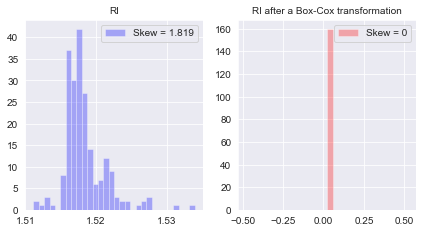

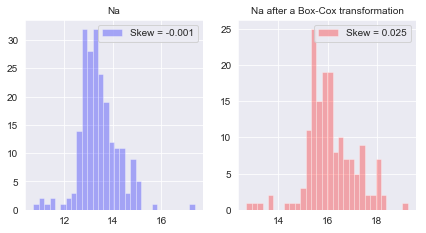

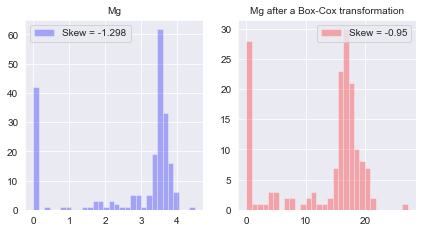

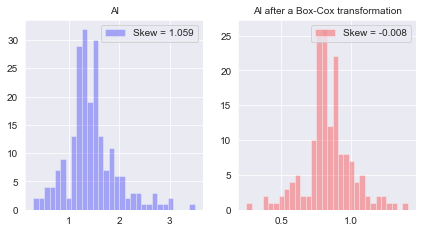

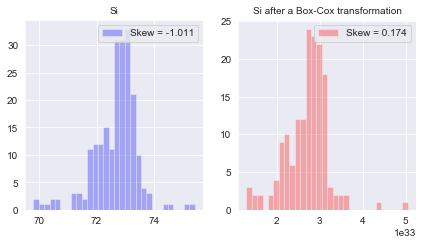

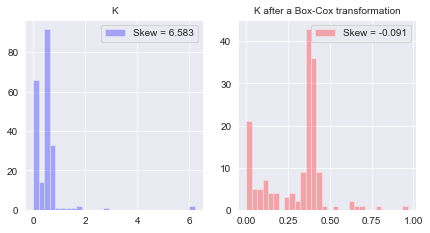

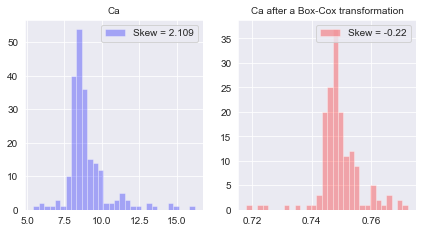

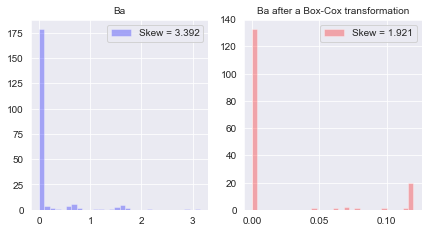

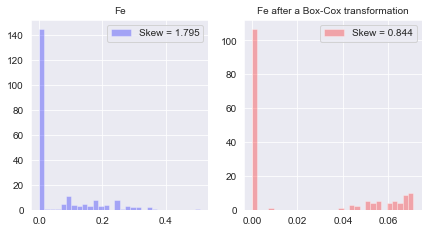

In [12]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Skew = %s' %(str(round(X_train[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Skew = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' after a Box-Cox transformation')
    ax[1].legend(loc=0)
    plt.show()

In [13]:
# check if skew is closer to zero after a box-cox transform
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('Feature %s is less skewed after a Box-Cox transform' %(feature))
    else:
        print('Feature %s is more skewed after a Box-Cox transform'  %(feature))

Feature RI is less skewed after a Box-Cox transform
Feature Na is less skewed after a Box-Cox transform
Feature Mg is less skewed after a Box-Cox transform
Feature Al is less skewed after a Box-Cox transform
Feature Si is less skewed after a Box-Cox transform
Feature K is less skewed after a Box-Cox transform
Feature Ca is less skewed after a Box-Cox transform
Feature Ba is less skewed after a Box-Cox transform
Feature Fe is less skewed after a Box-Cox transform
